In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import smogn
import pandas
from collections import Counter
import warnings
from itertools import compress
import scipy.stats as stats

In [3]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [4]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/laro/'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/roi/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/media/mts_dbs/ChanghaiDBS_QSM/nii/mask/'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/roi/'+seg_filename)
        mask = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/mask/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/media/mts_dbs/ChanghaiDBS_QSM/nii/laro/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1

        qsms_wl = np.asarray(qsms)
        laros_wl = np.asarray(laros)
        segs_wl = np.asarray(segs)



Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii QSM, 0000

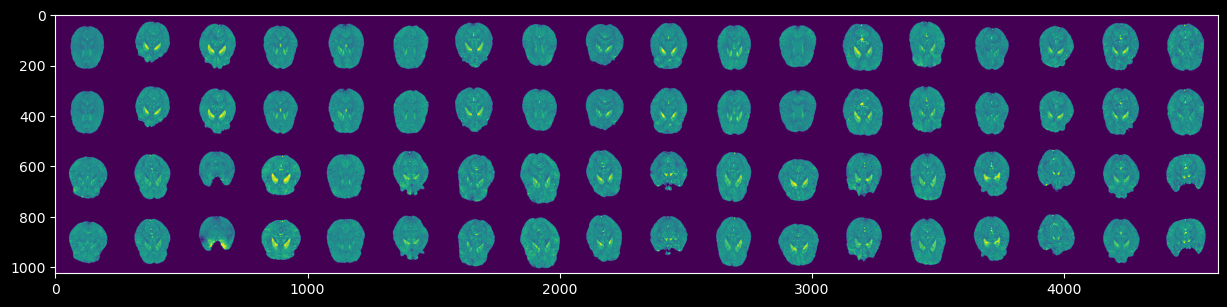

In [5]:
if visualize == 1:
    qsms_wl[qsms_wl < m1] = m1
    qsms_wl[qsms_wl > m2] = m2
    laros_wl[laros_wl < m1] = m1
    laros_wl[laros_wl > m2] = m2
    multi_slice_viewer(np.hstack(((np.vstack(qsms_wl[:n_cases//2,:,:,:]/1000+0*segs_wl[:n_cases//2,:,:,:]).T),
                                  (np.vstack(laros_wl[:n_cases//2,:,:,:]/1000+0*segs_wl[:n_cases//2,:,:,:]).T),
                                  (np.vstack(qsms_wl[(n_cases-n_cases//2):,:,:,:]/1000+0*segs_wl[(n_cases-n_cases//2):,:,:,:]).T),
                                  (np.vstack(laros_wl[(n_cases-n_cases//2):,:,:,:]/1000+0*segs_wl[(n_cases-n_cases//2):,:,:,:]).T))))
                                    
    label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
    label_max = np.amax(seg.get_fdata())

In [6]:
df = pd.read_csv("/media/mts_dbs/ChanghaiDBS_QSM/xlsx/updrs_iii_chh.csv")
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,NaN
1,1.0,62.26%,NaN,53,20,40,15,7,NaN
2,2.0,75.00%,NaN,32,8,26,17,10,NaN
3,3.0,51.72%,NaN,58,28,52,18,20,NaN
4,4.0,22.58%,NaN,62,48,61,36,28,NaN
5,5.0,55.88%,NaN,34,15,44,29,22,NaN
6,6.0,75.44%,NaN,57,14,55,32,16,NaN
7,7.0,84.00%,NaN,100,16,68,12,NaN,NaN
8,8.0,41.86%,NaN,43,25,48,26,26,NaN
9,9.0,72.58%,NaN,62,17,56,25,11,NaN


In [7]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')






Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [8]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [9]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('./npy/X0_gt_chh_rois.npy',X0_gt)
    np.save('./npy/X0_lr_chh_rois.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('./npy/K_chh.npy',K)
    np.save('./npy/R_chh.npy',R)

    print('Saving ground truth feature vector')
    with open('./phi/Phi_mcl_gt_roi_chh', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('./phi/Phi_mcl_lr_roi_chh', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('./npy/X0_gt_chh_rois.npy')
    X0_lr = np.load('./npy/X0_lr_chh_rois.npy')
    K = np.load('./npy/K_chh.npy')
    R = np.load('./npy/R_chh.npy')
    n_rois = R.shape[0]-1
    with open('./phi/Phi_mcl_gt_roi_chh', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('./phi/Phi_mcl_lr_roi_chh', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [10]:
# Compute number of features and check ROIs
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)

In [11]:
# Allocate arrays
x_row_gt = X0_gt.tolist()
X = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1))
X = X0_gt.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
ut_ls = np.zeros((subject_id_corr.__len__()))
ut_qr = np.zeros((subject_id_corr.__len__()))

# Normalize testing and training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
X_all = X.reshape(n_cases,((n_features)*n_rois))
# Add UPDRS
X_all_t = np.concatenate((X_all,pre_updrs_iii_off.reshape(pre_updrs_iii_off.__len__(),1)),axis=1)
scaler = StandardScaler()
# Transform feature matrix and UPDRS
X_all_t = scaler.fit_transform(X_all_t)

In [12]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Create data frame for SMOGN generation
D = pd.DataFrame(np.hstack((X_all_t,(per_change.reshape(per_change.__len__(),1)))))
for col in D.columns:
    D.rename(columns={col:str(col)},inplace=True)

# Specify phi relevance values
Rm = [[np.min(per_change),  1, 0],  ## over-sample ("minority")
    [np.median(per_change), 0, 0],  ## under-sample ("majority")
    ]

# Conduct SMOGN
print('Prior to SMOGN sampling, mean is',X_all_t.mean(),'and standard deviation is',X_all_t.std())
X_smogn = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm)

# Drop label
X_in_s = np.array(X_smogn)[:,:-1] 
print('After SMOGN sampling, mean is',X_in_s.mean(),'and standard deviation is',X_in_s.std())
X_in_s = scaler.fit_transform(X_in_s)
print('Standardizing the SMOGN dataset gives, mean',X_in_s.mean(),'standard deviation',X_in_s.std())

for j in np.arange(X_in_s.shape[1]):
    if np.array_equal(X_in_s[:,j],np.array(X_smogn)[:,-1]) == 0:
        next
    else:
        print('Labels detected at column',j)

Prior to SMOGN sampling, mean is 6.524413910284011e-16 and standard deviation is 0.942316687356841


r_index: 100%|##########| 4/4 [00:05<00:00,  1.43s/it]


After SMOGN sampling, mean is 0.16554800837868186 and standard deviation is 0.9361712657265846
Standardizing the SMOGN dataset gives, mean 1.5394968953766398e-18 standard deviation 0.9414298008663616


In [13]:
from smogn.phi import phi
from smogn.phi_ctrl_pts import phi_ctrl_pts
from smogn.over_sampling import over_sampling

In [14]:
d = len(D.columns)
y = pd.DataFrame(D[str(d-1)])
y_sort = y.sort_values(by=str(d-1))
y_sort = y_sort[str(d-1)]

In [15]:
y_sort

18    0.096774
4     0.147059
24    0.283333
12    0.307692
35    0.315217
30    0.333333
14    0.338028
7     0.395349
19    0.414634
3     0.419355
5     0.438596
1     0.468750
23    0.470588
28    0.481481
31    0.494624
26    0.529412
20    0.571429
15    0.588235
25    0.594937
8     0.596774
22    0.628205
10    0.638298
29    0.655738
21    0.655738
13    0.680000
2     0.689655
34    0.714286
11    0.716418
0     0.716981
32    0.777778
33    0.807018
9     0.812500
36    0.833333
17    0.836735
27    0.860465
6     0.880000
16    0.938776
Name: 9577, dtype: float64

In [16]:
Rmt = [[np.min(per_change),  1, 0],  ## over-sample ("minority")
    [0.5, 0, 0],  ## under-sample ("majority")
    [np.max(per_change), 1, 0]
    ]
phi_params = phi_ctrl_pts(y = y_sort,               ## y (ascending)
        method = 'manual',       ## defaults "auto" 
        xtrm_type = 'both', ## defaults "both"
        coef = 1.5,           ## defaults 1.5
        ctrl_pts = Rmt ## user spec
    )
y_phi = phi(y = y_sort,                ## y (ascending)
    ctrl_pts = phi_params      ## from 'phi_ctrl_pts()'
)

(0.0, 1.0)

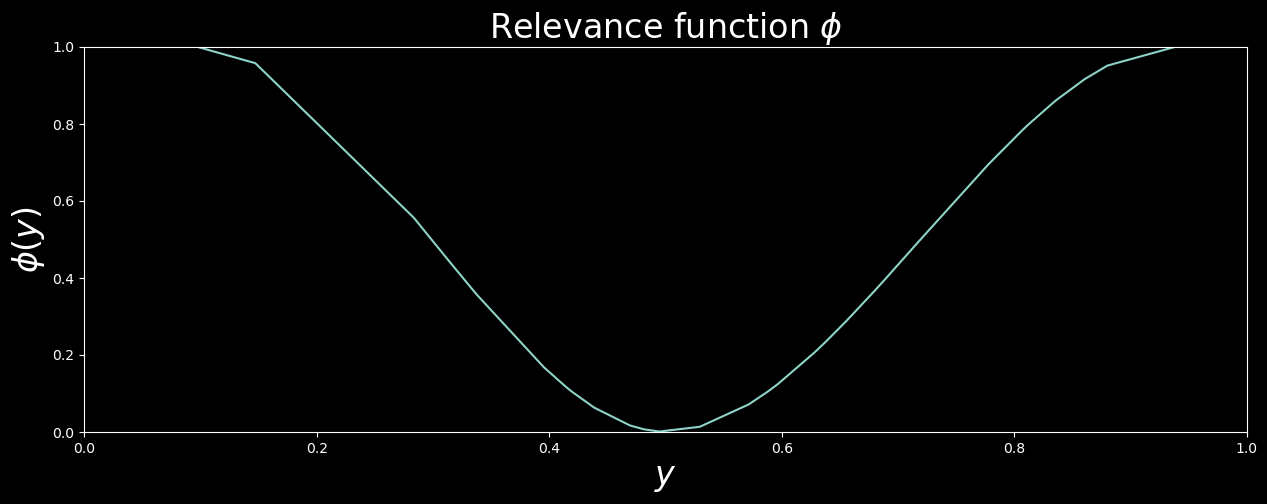

In [17]:
plt.plot(y_sort,y_phi)
plt.title(r'Relevance function $\phi$',FontSize=24)
plt.xlabel(r'$y$',FontSize=24)
plt.ylabel(r'$\phi(y)$',FontSize=24)
plt.xlim([0,1])
plt.ylim([0,1])

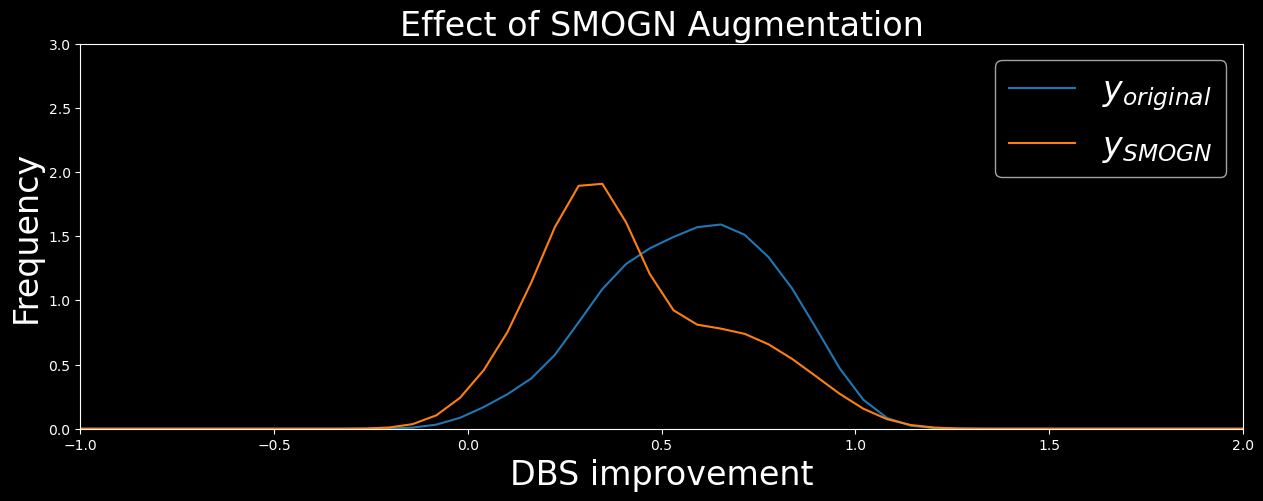

In [18]:
density = stats.gaussian_kde(per_change)
n, x, _ = plt.hist(per_change, bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:blue',linewidth=0)  
plt.plot(x, density(x),color='tab:blue',label=r'$y_{original}$')
density = stats.gaussian_kde(np.array(X_smogn)[:,-1])
n, y, _ = plt.hist(np.array(X_smogn)[:,-1], bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:orange',linewidth=0)  
plt.plot(y, density(y),color='tab:orange',label=r'$y_{SMOGN}$')
plt.legend(fontsize=24)
plt.xlim([-1,2])
plt.ylim([0,3])
plt.xlabel('DBS improvement',FontSize=24)
plt.ylabel('Frequency',FontSize=24)
plt.title('Effect of SMOGN Augmentation',FontSize=24)
plt.show()

In [19]:
Cs = np.zeros_like(X_in_s)
C = np.zeros_like(X_all_t)
for j in np.arange(len(subject_id_corr)):
        # Add UPDRS after scaling
        # Initialize training feature matrix
        X_in = X_all_t
        X_in = np.delete(X_in,j,axis=0)
        if j < np.array(X_smogn)[:,:-1].shape[0]: 
                # Drop the label in SMOGN array
                X_in_s = np.array(X_smogn)[:,:-1] 
                # Drop the test case features
                X_in_s = np.delete(X_in_s,j,axis=0)
                # Create training label array from the SMOGN array
                smogn_per_change_in = np.asarray(X_smogn)[:,-1]
                # Drop the test case labels
                smogn_per_change_in = np.delete(smogn_per_change_in,j,axis=0)
                # Train LASSO on SMOGN
                clf_s = Lasso(alpha=1e-4,max_iter=10000).fit(X_in_s,smogn_per_change_in)
                # Get the features LASSO-SMOGN uses
                Cs[j] = clf_s.coef_

        # Initialize training labels
        per_change_in = per_change
        per_change_in = np.delete(per_change_in,j,axis=0)
  
        # Cross-validation for model selection
        # Identify most important features
        clf_ls = Lasso(alpha=1e-4,max_iter=10000).fit(X_in,per_change_in)
        print('Fit complete')
        # Predict on real data with both models
        ut_ls[j] = clf_ls.predict(X_all_t[j,:].reshape(1, -1))
        ut_qr[j] = clf_s.predict(X_all_t[j,:].reshape(1, -1))
        C[j] = clf_ls.coef_

        print('Patient ID',str(subject_id_corr[j]),'with pre-surgical UPDRS score',str(pre_updrs_iii_off[int(j)]),'at feature matrix row',str(j))

Fit complete
Patient ID 1.0 with pre-surgical UPDRS score 53 at feature matrix row 0
Fit complete
Patient ID 2.0 with pre-surgical UPDRS score 32 at feature matrix row 1
Fit complete
Patient ID 3.0 with pre-surgical UPDRS score 58 at feature matrix row 2
Fit complete
Patient ID 4.0 with pre-surgical UPDRS score 62 at feature matrix row 3
Fit complete
Patient ID 5.0 with pre-surgical UPDRS score 34 at feature matrix row 4
Fit complete
Patient ID 6.0 with pre-surgical UPDRS score 57 at feature matrix row 5
Fit complete
Patient ID 7.0 with pre-surgical UPDRS score 100 at feature matrix row 6
Fit complete
Patient ID 8.0 with pre-surgical UPDRS score 43 at feature matrix row 7
Fit complete
Patient ID 9.0 with pre-surgical UPDRS score 62 at feature matrix row 8
Fit complete
Patient ID 10.0 with pre-surgical UPDRS score 64 at feature matrix row 9
Fit complete
Patient ID 11.0 with pre-surgical UPDRS score 94 at feature matrix row 10
Fit complete
Patient ID 13.0 with pre-surgical UPDRS score 67

<function matplotlib.pyplot.show(*args, **kw)>

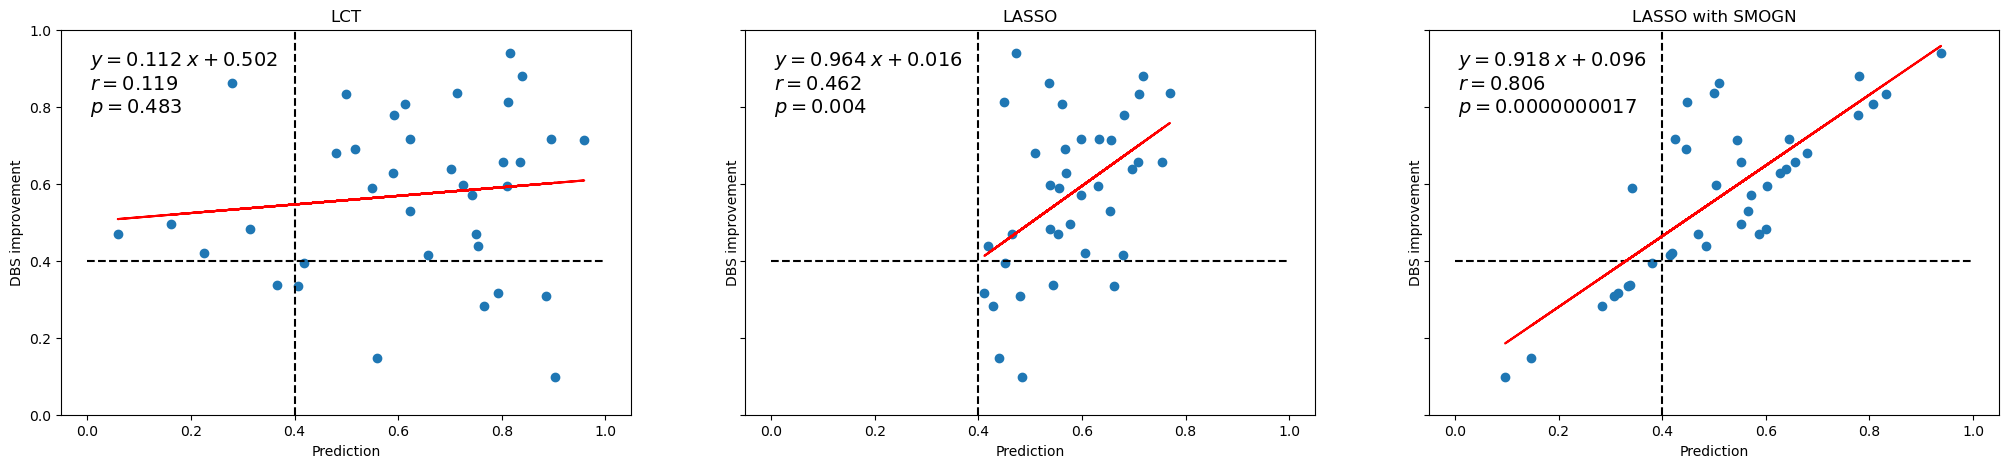

In [40]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,5)
# Cross validation results
[fig,ax] = plt.subplots(1,3,sharex=True, sharey=True)
lr_prepost = linregress(lct_change,per_change)
ax[0].scatter(lct_change,per_change,)
ax[0].plot(lct_change,lct_change*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
ax[0].set_ylim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.05, 0.95, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.4,0,1,linestyle='dashed',color='black')
ax[0].vlines(0.4,0,2,linestyle='dashed',color='black')

lr_pred_ls = linregress(ut_ls,per_change)
ax[1].scatter(ut_ls,per_change)
ax[1].plot(ut_ls,ut_ls*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[1].set_title('LASSO')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[1].text(0.05, 0.95, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.4,0,1,linestyle='dashed',color='black')
ax[1].vlines(0.4,0,2,linestyle='dashed',color='black')


lr_pred_qr = linregress(ut_qr,per_change)
ax[2].scatter(ut_qr,per_change)
ax[2].plot(ut_qr,ut_qr*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[2].set_title('LASSO with SMOGN')
ax[2].set_ylabel("DBS improvement")
ax[2].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.10f}$"
ax[2].text(0.05, 0.95, text,transform=ax[2].transAxes,
     fontsize=14, verticalalignment='top')
ax[2].hlines(0.4,0,1,linestyle='dashed',color='black')
ax[2].vlines(0.4,0,2,linestyle='dashed',color='black')

plt.style.use('default')
plt.show

1596

In [34]:
C.shape

(37, 9577)

In [31]:
rfs = []
rfss = []
for j in np.arange(subject_id_corr.__len__()):
    Kr =  K.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    Kr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    Kr_extended[:,0:n_features-1,:] = Kr
    Kr_extended[:,-1,:] = 'po_updrs'
    rfs.append(Kr_extended[j,np.asarray(C[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
    if j < Cs.shape[0]:
        rfss.append(Kr_extended[j,np.asarray(Cs[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])

ValueError: cannot reshape array of size 9577 into shape (6,1596)

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
fig, axes = plt.subplots(3,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in rfs for item in sublist]
letter_counts = Counter(R)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')


Rs = [item for sublist in rfss for item in sublist]
letter_countss = Counter(Rs)
dfs = pandas.DataFrame.from_dict(letter_countss, orient='index')


uL = list(compress(R, np.in1d(R,Rs)))
colors = np.zeros_like(R)
for j in np.arange(R.__len__()):
    if R[j] in uL:
        colors[j] = "tab:orange"
    else:
        colors[j] = "tab:blue"


df.sort_values(0, inplace=True)
df.plot(ax=axes[0],y=0, kind='bar', legend=False, color=colors)
dfs.sort_values(0, inplace=True)
dfs.plot(ax=axes[1],y=0, kind='bar', legend=False, color=colors)




In [ ]:
dfu

In [ ]:
plt.figure()
plt.rcParams.update({'figure.figsize':(30,60)})
plt.rcParams.update({'font.size': 24})
uL = list(compress(R, np.in1d(R,Rs)))
colors = np.zeros_like(R)
for j in np.arange(R.__len__()):
    if R[j] in uL:
        Ru.append(R[j])
letter_countsu = Counter(Ru)
dfu = pandas.DataFrame.from_dict(letter_countsu, orient='index')
dfu.sort_values(0, inplace=True)

dfu.plot(y=0, kind='bar', legend=False, color='tab:orange')


In [ ]:
Ru